In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from transformers import BertModel, BertConfig

from transformers import *
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import textwrap
import math
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')
clear_output()

In [2]:
df_train = pd.read_csv('/home/m_nsu/ICLR/Datasets/GoEmotion/train.csv')
df_val = pd.read_csv('/home/m_nsu/ICLR/Datasets/GoEmotion/val.csv')
df_test = pd.read_csv('/home/m_nsu/ICLR/Datasets/GoEmotion/test.csv')

In [3]:
df_senti = pd.read_excel('/home/m_nsu/ICLR/Datasets/GoEmotion/sentiwords.xlsx')
conditions = [
    (df_senti['PosScore'] > df_senti['NegScore']),
    (df_senti['PosScore'] < df_senti['NegScore']),
    (df_senti['PosScore'] == df_senti['NegScore'])
    ]

values = ['Positive','Negative','Neutral']

df_senti = df_senti[['PosScore','NegScore','Word','Definition']]
df_senti['Sentiment'] = np.select(conditions, values)
df_senti = df_senti.dropna(axis=0)
df_senti.drop(columns=['PosScore', 'NegScore'], inplace=True)
df_senti = df_senti[['Word', 'Sentiment', 'Definition']]

In [4]:
df_train.dropna(inplace=True)

In [5]:
df_train.rename(columns={'Text': 'review'}, inplace=True)
df_val.rename(columns={'Text': 'review'}, inplace=True)
df_test.rename(columns={'Text': 'review'}, inplace=True)


df_train.rename(columns={'Mapped Sentiment': 'sentiment'}, inplace=True)
df_val.rename(columns={'Mapped Sentiment': 'sentiment'}, inplace=True)
df_test.rename(columns={'Mapped Sentiment': 'sentiment'}, inplace=True)

In [6]:
df_train.head()

,review,Emotions,sentiment
0,my favorite food is anything i did not have to...,neutral,3
1,now if he does off himself everyone will think...,neutral,3
2,why the fuck is bayless isoing,anger,1
3,to make her feel threatened,fear,1
4,dirty southern wankers,annoyance,1


In [7]:
def filter_rows_by_values(df, col, values):
    return df[~df[col].isin(values)]

df_train = filter_rows_by_values(df_train,'sentiment',[2,3])
df_test = filter_rows_by_values(df_test,'sentiment',[2,3])
df_val = filter_rows_by_values(df_val,'sentiment',[2,3])

In [8]:
df_train['emotion'], map = pd.factorize(df_train['Emotions'])

In [9]:
emotion_map = dict(zip(map, range(len(map))))
map_emotion = {v: k for k, v in emotion_map.items()}

In [10]:
emotion_map['gratitude']  # Get Encoded Label from Categorical Label
map_emotion[3]  # Get Categorical Label from Encoded Label

'gratitude'

In [11]:
df_val['emotion'] = df_val["Emotions"].apply(lambda x: emotion_map[x])
df_test['emotion'] = df_test["Emotions"].apply(lambda x: emotion_map[x])

In [12]:
MAX_LEN = 200
RANDOM_SEED = 42
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
config = BertConfig.from_pretrained(PRE_TRAINED_MODEL_NAME)
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
clear_output()
print(device)

cuda


In [14]:
pre_trained_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME).to(device)
clear_output()

In [15]:
def get_cls(sent):
  encoded_review = tokenizer.encode_plus(
  sent,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  truncation = True,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',
  )
  input_ids = encoded_review['input_ids'].to(device)
  attention_mask = encoded_review['attention_mask'].to(device)

  pre_trained_model.eval()
  with torch.no_grad():
    output = pre_trained_model(input_ids, attention_mask)
    return torch.mean(output[0], dim=1)[0] #Output Avg pooled vector embedding of last layer

In [16]:
positive_words = ['amusement','excitement','joy','love','desire','optimism','caring','pride','admiration','gratitude','relief','approval']
negative_words = ['fear','nervousness','remorse','embarrassment','disappointment','sadness','grief','disgust','anger','annoyance','disapproval']

In [17]:
pos_word_map = [emotion_map[i] for i in positive_words]
neg_word_map = [emotion_map[i] for i in negative_words]

In [18]:
pos_word_map = dict(zip(range(len(pos_word_map)),pos_word_map))
neg_word_map = dict(zip(range(len(neg_word_map)),neg_word_map))

In [19]:
positive_word_meaning_sentences = ['the feeling that you have when you enjoy something that is funny',#amusement
                                   'the state of feeling or showing happiness and enthusiasm',#excitement
                                   'a feeling of great happiness',#joy
                                   'a very strong feeling of liking and caring for somebody/something, especially a member of your family or a friend',#love
                                   'a strong wish to have or do something',#desire
                                   'a feeling that good things will happen and that something will be successful',#optimism
                                   'kind, helpful and showing that you care about other people',#caring
                                   'a feeling of being pleased or satisfied that you get when you or people who are connected with you have done something well or own something that other people admire',#pride
                                   'a feeling of respect for and approval of somebody/something',#admiration
                                   'the feeling of being grateful and wanting to express your thanks',#gratitude
                                   'the feeling of happiness that you have when something unpleasant stops or does not happen',#relief
                                   'the feeling that somebody/something is good or acceptable; a positive opinion of somebody/something',#approval
]

negative_word_meaning_sentences = ['the bad feeling that you have when you are in danger or when a particular thing frightens you',#fear
                                   'the feeling of being anxious about something or afraid of something',#nervousness
                                   'the feeling of being extremely sorry for something wrong or bad that you have done',#remorse
                                   'shy, uncomfortable or guilty feelings; a feeling of being embarrassed',#embarrassment
                                   'the feeling of being sad because something has not happened or been as good, successful, etc. as you expected or hoped',#disappointment
                                   'the feeling of being sad',#sadness
                                   'a very sad feeling, especially when somebody dies',#grief
                                   'a strong feeling of dislike for somebody/something that you feel is unacceptable, or for something that looks, smells, etc. unpleasant',#disgust
                                   'the strong feeling that you have when something has happened that you think is bad and unfair',#anger
                                   'the feeling of being slightly angry',#annoyance
                                   'a feeling that you do not like an idea, an action or somebody’s behaviour because you think it is bad, not suitable or going to have a bad effect on somebody else',#disapproval
]


'''
ambiguous_word_meaning_sentences = ['the process of becoming aware of something',#realization
                                'an event, a piece of news, etc. that is unexpected or that happens suddenly',#surprise
                                ' a strong desire to know about something',#curiosity
                                'a state of not being certain about what is happening, what you should do, what something means, etc.',#confusion
]

neutral_word_meaning_sentences = ['not supporting or helping either side in a disagreement, competition, etc.']
'''

"\nambiguous_word_meaning_sentences = ['the process of becoming aware of something',#realization\n                                'an event, a piece of news, etc. that is unexpected or that happens suddenly',#surprise\n                                ' a strong desire to know about something',#curiosity\n                                'a state of not being certain about what is happening, what you should do, what something means, etc.',#confusion\n]\n\nneutral_word_meaning_sentences = ['not supporting or helping either side in a disagreement, competition, etc.']\n"

In [20]:
print(len(positive_word_meaning_sentences))
print(len(negative_word_meaning_sentences))

12
11


In [21]:
p_emb = torch.tensor([[1.]*config.hidden_size]).to(device)
n_emb = torch.tensor([[1.]*config.hidden_size]).to(device)


for i in positive_word_meaning_sentences:
  p_emb = torch.cat((p_emb,get_cls(i).unsqueeze(dim=0)), dim=0)

for i in negative_word_meaning_sentences:
  n_emb = torch.cat((n_emb,get_cls(i).unsqueeze(dim=0)), dim=0)



p_emb = p_emb[1:]
n_emb = n_emb[1:]

In [22]:
print(p_emb.shape)
print(n_emb.shape)

torch.Size([12, 768])
torch.Size([11, 768])


In [23]:
#df_train = df_train[:100]
#df_test = df_test[:100]
#df_val = df_val[:100]

In [24]:
class IMDBDataset(Dataset):

  def __init__(self, reviews, sentiments, emotions, tokenizer, max_len):
    self.reviews = reviews
    self.sentiments = sentiments
    self.emotions = emotions
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)

  def __getitem__(self, item):
    review = str(self.reviews[item])
    sentiment = self.sentiments[item]
    emotion = self.emotions[item]


    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      truncation = True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'sentiments': torch.tensor(sentiment, dtype=torch.long),
      'emotions': torch.tensor(emotion, dtype=torch.long),

    }

In [25]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = IMDBDataset(
    reviews=df.review.to_numpy(),
    sentiments=df['sentiment'].to_numpy(),
    emotions=df['emotion'].to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=8
  )

In [26]:
BATCH_SIZE = 32

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [27]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review', 'input_ids', 'attention_mask', 'sentiments', 'emotions'])

In [28]:
class Classifier(nn.Module):
  def __init__(self):
    super(Classifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME,config=config)
    self.FC_p = nn.Linear(config.hidden_size,config.hidden_size, bias=False)
    self.FC_n = nn.Linear(config.hidden_size,config.hidden_size, bias=False)
    

  def CosineNorm(self, c, b, n_words):
    cos = torch.nn.CosineSimilarity(dim=-1, eps=1e-8)
    simi = torch.tensor([[1.]*n_words]).to(device)
    for i in c:
      temp = cos(i,b).to(device)
      temp = torch.unsqueeze(temp,0)
      simi = torch.cat((simi,temp), dim=0)

    return simi[1:]

  def binary_output(self,positive, negative):
    positive = torch.max(positive,1).values
    negative = torch.max(negative,1).values

    p_temp = torch.unsqueeze(positive,0)
    n_temp = torch.unsqueeze(negative,0)


    res = torch.cat((p_temp,n_temp), dim=0)

    return torch.t(res)

  def forward(self, input_ids, attention_mask, return_scores=False):
    with torch.no_grad():
      pooled_output = self.bert(
        input_ids=input_ids,
        attention_mask=attention_mask,
        return_dict = False
      )
    pooled_output = torch.mean(pooled_output[0], dim=1) # Taking Averge pooled last layer embedding

    x_sent_p = self.FC_p(pooled_output)
    x_sent_n = self.FC_n(pooled_output)
    

    Ept = self.FC_p(p_emb)
    Ent = self.FC_n(n_emb)

    positive = F.relu(self.CosineNorm(x_sent_p, Ept, p_emb.size()[0]))
    negative = F.relu(self.CosineNorm(x_sent_n, Ent, n_emb.size()[0]))

    binary_out = self.binary_output(positive,negative)
    if(return_scores==True):
      return (positive,negative) , binary_out
    return binary_out

In [29]:
model = Classifier()
model = model.to(device)
clear_output()

In [30]:
for name, param in model.named_parameters():
    if name.startswith('bert'):
        param.requires_grad = False

In [31]:
#for name, param in model.named_parameters():
#    print(name, param.requires_grad)

In [32]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
sentiments = data['sentiments'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([32, 200])
torch.Size([32, 200])


In [33]:
#del test
torch.cuda.empty_cache()

In [34]:
(positive,negative),outs = model(input_ids, attention_mask,return_scores=True)

In [35]:
outs

tensor([[0.6931, 0.7351],
        [0.8051, 0.8642],
        [0.6433, 0.7368],
        [0.7226, 0.7579],
        [0.7086, 0.7584],
        [0.8050, 0.8263],
        [0.7665, 0.7864],
        [0.7547, 0.7517],
        [0.7270, 0.7549],
        [0.7705, 0.8241],
        [0.7193, 0.7411],
        [0.7094, 0.6865],
        [0.6715, 0.7525],
        [0.8346, 0.8122],
        [0.6697, 0.6891],
        [0.7430, 0.7806],
        [0.7822, 0.8144],
        [0.7600, 0.7852],
        [0.7723, 0.8251],
        [0.8221, 0.8400],
        [0.7135, 0.7711],
        [0.7531, 0.7876],
        [0.7183, 0.7598],
        [0.7033, 0.7550],
        [0.7596, 0.7774],
        [0.7154, 0.7440],
        [0.8161, 0.7920],
        [0.7428, 0.7854],
        [0.7678, 0.7881],
        [0.7763, 0.8461],
        [0.6667, 0.7107],
        [0.8496, 0.8634]], device='cuda:0', grad_fn=<TBackward0>)

In [36]:
EPOCHS = 8

optimizer = AdamW(model.parameters(), lr=0.001)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=math.floor((1./5)*total_steps),
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [37]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    sentiments = d["sentiments"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    ).to(device)

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, sentiments)

    correct_predictions += torch.sum(preds == sentiments)
    losses.append(loss.item())


    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [38]:
def eval_model(model, data_loader, loss_fn, device, n_examples, on_new=False):
  model = model.eval()

  losses = []
  f1s = []

  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      sentiments = d["sentiments"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
      ).to(device)
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, sentiments)

      correct_predictions += torch.sum(preds == sentiments)
      losses.append(loss.item())

      f1s.append(f1_score(sentiments.cpu(), preds.cpu(), average='macro'))

  return correct_predictions.double() / n_examples, np.mean(losses), np.mean(f1s)

In [39]:
def batch_calc_score_sum(positive, negative, sentiments):
  p_filter = sentiments ^ torch.ones(sentiments.size()[0], dtype=torch.int8).to(device) # Positive ( sentiment xor [1,1,...])
  n_filter = sentiments # Negative

  pos_score_pos_sent = positive[p_filter.nonzero(), :]
  pos_score_neg_sent = positive[n_filter.nonzero(), :]

  neg_score_pos_sent = negative[p_filter.nonzero(), :]
  neg_score_neg_sent = negative[n_filter.nonzero(), :]

  pp_count = pos_score_pos_sent.size()[0]
  pn_count = pos_score_neg_sent.size()[0]
  pp_sum = torch.sum(pos_score_pos_sent,dim=0)
  pn_sum = torch.sum(pos_score_neg_sent,dim=0)


#  np_count = neg_score_pos_sent.size()[0] # same as pn_count
#  nn_count = neg_score_neg_sent.size()[0] # same as pn_count
  np_sum = torch.sum(neg_score_pos_sent,dim=0)
  nn_sum = torch.sum(neg_score_neg_sent,dim=0)

  return pp_sum,pn_sum,np_sum,nn_sum, pp_count, pn_count

def eval_scores_average(model, data_loader, device):
  model = model.eval()


  pp_sum_agg = torch.zeros(1,p_emb.size()[0]).to(device)
  pn_sum_agg = torch.zeros(1,p_emb.size()[0]).to(device)

  np_sum_agg = torch.zeros(1,n_emb.size()[0]).to(device)
  nn_sum_agg = torch.zeros(1,n_emb.size()[0]).to(device)

  pp_count_agg, pn_count_agg = 0,0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      sentiments = d["sentiments"].to(device)

      (positive,negative),_= model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        return_scores=True
      )
      positive.to(device)
      negative.to(device)


      pp_sum,pn_sum,np_sum,nn_sum, pp_count, pn_count = batch_calc_score_sum(positive,negative,sentiments)

      pp_sum_agg += pp_sum
      pn_sum_agg += pn_sum

      np_sum_agg += np_sum
      nn_sum_agg += nn_sum

      pp_count_agg += pp_count
      pn_count_agg += pn_count



  return pp_sum_agg/pp_count_agg, pn_sum_agg/pn_count_agg, np_sum_agg/pp_count_agg, nn_sum_agg/pn_count_agg

In [40]:
def box_plot(pp,pn,np,nn):
  pp = pp.tolist()[0]
  pn = pn.tolist()[0]
  np = np.tolist()[0]
  nn = nn.tolist()[0]
  # Create a box plot with beeswarm using seaborn
  sns.set(style="whitegrid")  # Set the style of the plot
  plt.figure(figsize=(8, 6))  # Set the figure size
  ax = sns.boxplot(data=[pp,pn,np,nn], orient="v", palette="Set2")  # Create the box plot
  ax = sns.swarmplot(data=[pp,pn,np,nn], orient="v", color="0.2")  # Add the swarm plot

  # Set labels for the axes
  ax.set_xlabel('Categories')
  ax.set_xticklabels(['pp','pn','np','nn'])
  ax.set_ylabel('Scores(µ)')

  # Set a title for the plot
  #plt.title()

  # Show the plot
  plt.show()

In [41]:
def max_emotion(a,b):
  emotion_list = []

  max_a_values = torch.stack((torch.max(a,1).values, torch.max(b,1).values))
  max_a_indices = torch.stack((torch.max(a,1).indices, torch.max(b,1).indices))
  agg_max = torch.max(max_a_values,0)
  emotions_indices = [i[1][agg_max.indices[i[0]]] for i in enumerate(max_a_indices.t())]

  emotions_indices = torch.stack(emotions_indices)
  for i in range(len(emotions_indices)):
    if(agg_max.indices[i] == 0):
      emotion_list.append(pos_word_map[emotions_indices[i].item()])
    else:
      emotion_list.append(neg_word_map[emotions_indices[i].item()])
  return torch.tensor(emotion_list)


In [42]:
def eval_emotions(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      emotions = d["emotions"].to(device)

      (a,b), _ = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        return_scores = True
      )

      preds = max_emotion(a,b).to(device)
      correct_predictions += torch.sum(preds == emotions)

  return correct_predictions.double() / n_examples

In [43]:
%%time

train_a = []
train_l = []
val_a = []
val_l = []
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss, val_f1 = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  train_a.append(train_acc)
  train_l.append(train_loss)
  val_a.append(val_acc)
  val_l.append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'goemot_bert_best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/8
----------
Train loss 0.5314175793198483 accuracy 0.7767462866318747
Val   loss 0.48213750501222247 accuracy 0.828639428798096

Epoch 2/8
----------
Train loss 0.48967919796466064 accuracy 0.8183460457647531
Val   loss 0.47356011746804927 accuracy 0.8361761205870686

Epoch 3/8
----------
Train loss 0.4793056096062423 accuracy 0.8276294660778803
Val   loss 0.46944211404534836 accuracy 0.8381594605315351

Epoch 4/8
----------
Train loss 0.47518329463456643 accuracy 0.8315937374548374
Val   loss 0.4695041870014577 accuracy 0.8377627925426419

Epoch 5/8
----------
Train loss 0.47127917858609036 accuracy 0.8378161380971497
Val   loss 0.46625023212613936 accuracy 0.8389527965093218

Epoch 6/8
----------
Train loss 0.4687215634180684 accuracy 0.8399237254114814
Val   loss 0.4663801034794578 accuracy 0.8405394684648949

Epoch 7/8
----------
Train loss 0.4660437993980334 accuracy 0.8421316740264955
Val   loss 0.4643342721311352 accuracy 0.8421261404204681

Epoch 8/8
----------
Train l

In [44]:
train_a = [i.item() for i in train_a]
train_l = [i.item() for i in train_l]
val_a = [i.item() for i in val_a]
val_l = [i.item() for i in val_l]

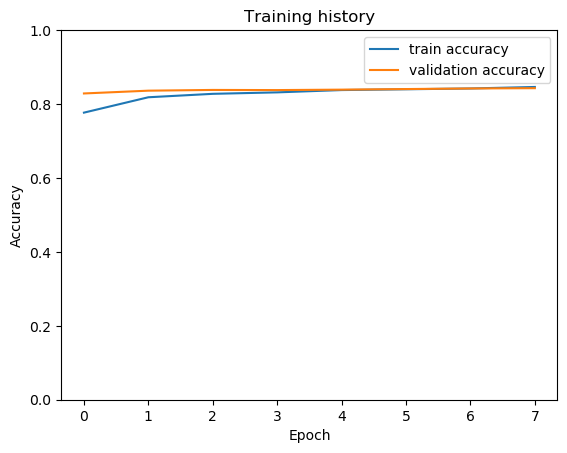

In [45]:
plt.plot(train_a, label='train accuracy')
plt.plot(val_a, label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])
plt.show()

Accuracy of Pos/Neg on Test Set

In [46]:
import numpy as np
test_acc, _, test_f1 = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)


print("Accuracy: ",test_acc.item())
print("F1-Macro: ",test_f1.item())

Accuracy:  0.831163708086785
F1-Macro:  0.8107517623571312


Scores Average of PP - Poisitve Scores on Positive Sentences
                  PN - Poisitve Scores on Negative Sentences
                  NP - Negative Scores on Positive Sentences
                  NN - Negative Scores on Negative Sentences

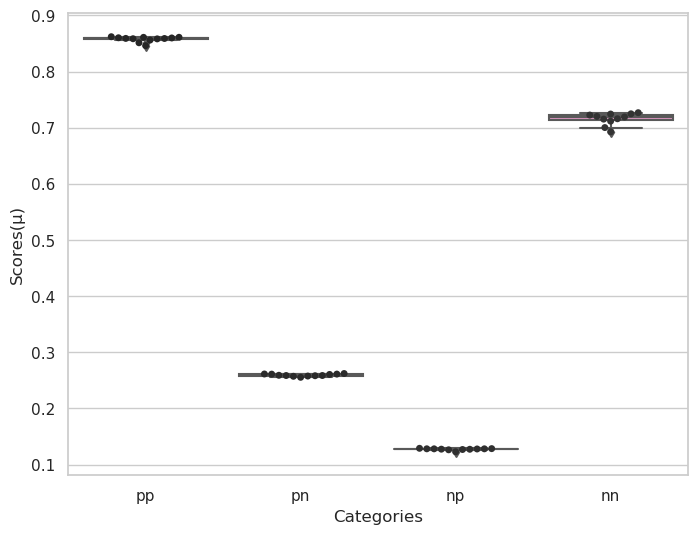

In [47]:
pp,pn,np,nn = eval_scores_average(
  model,
  test_data_loader,
  device,
)

box_plot(pp,pn,np,nn)

Accuracy of Emotions on Test Set

In [48]:
emotion_test_acc = eval_emotions(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

emotion_test_acc.item()

0.08284023668639053

In [49]:
def get_predictions(model, data_loader):
  model = model.eval()

  review = []
  predictions = []
  emo_predictions = []

  prediction_probs = []
  real_values = []
  emo_real_values = []

  pos_scores = []
  neg_scores = []


  with torch.no_grad():
    for d in data_loader:

      reviews = d["review"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      sentiments = d["sentiments"].to(device)
      emotions = d["emotions"].to(device)


      scores,outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        return_scores=True,
      )
      _, preds = torch.max(outputs, dim=1)

      emo_preds = max_emotion(scores[0],scores[1]).to(device)

      probs = F.softmax(outputs, dim=1)

      review.extend(reviews)
      predictions.extend(preds)
      emo_predictions.extend(emo_preds)

      prediction_probs.extend(probs)
      real_values.extend(sentiments)
      emo_real_values.extend(emotions)

      pos_scores.extend(scores[0])
      neg_scores.extend(scores[1])


  predictions = torch.stack(predictions).cpu()
  emo_predictions = torch.stack(emo_predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  emo_real_values = torch.stack(emo_real_values).cpu()
  pos_scores = torch.stack(pos_scores).cpu()
  neg_scores = torch.stack(neg_scores).cpu()
  return review, predictions, emo_predictions, prediction_probs, real_values, emo_real_values, pos_scores, neg_scores

In [50]:
y_review_texts, y_pred, emo_pred , y_pred_probs, y_test, emo_y_test, pos_scores, neg_scores = get_predictions(
  model,
  test_data_loader
)

In [51]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
class_names = ['negative', 'positive']

Pos/Neg Classification Report

In [52]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.86      0.88      0.87      1603
    positive       0.78      0.75      0.77       932

    accuracy                           0.83      2535
   macro avg       0.82      0.81      0.82      2535
weighted avg       0.83      0.83      0.83      2535



Emotion Classification Report

In [53]:
class_names = list(emotion_map.keys())

print(classification_report(emo_y_test, emo_pred, target_names=class_names))

                precision    recall  f1-score   support

         anger       0.12      0.02      0.04       131
          fear       0.11      0.37      0.17        65
     annoyance       0.12      0.03      0.05       194
     gratitude       0.14      0.11      0.13       260
    admiration       0.15      0.02      0.03       348
        caring       0.02      0.01      0.01        86
 embarrassment       0.01      0.13      0.03        23
           joy       0.08      0.14      0.10        93
       sadness       0.28      0.10      0.14       102
   disapproval       0.18      0.04      0.06       195
      optimism       0.06      0.21      0.10       107
      approval       0.17      0.00      0.01       236
    excitement       0.00      0.00      0.00        57
     amusement       0.10      0.22      0.14       186
disappointment       0.29      0.07      0.11        88
       remorse       0.00      0.00      0.00        44
          love       0.11      0.19      0.14  

Reverse Native Injection Accuracy

In [54]:
import numpy as np
p_emb, n_emb = n_emb, p_emb


test_acc, _, test_f1 = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

print("Accuracy: ",test_acc.item())
print("F1-Macro: ",test_f1.item())

Accuracy:  0.6343195266272189
F1-Macro:  0.5622920369898934


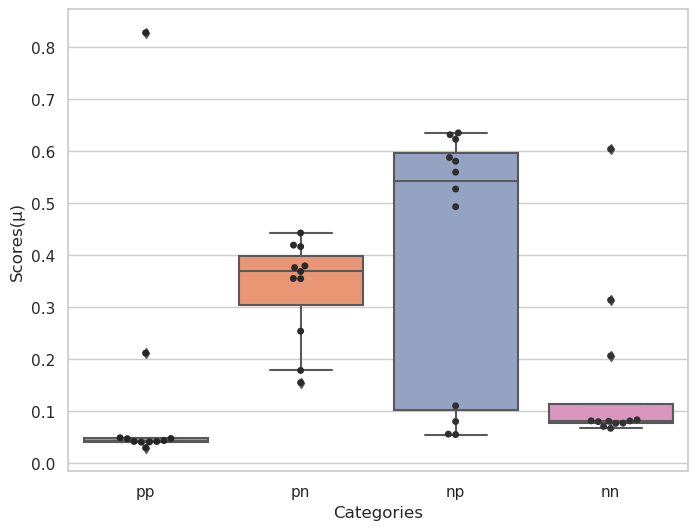

In [55]:
pp,pn,np,nn = eval_scores_average(
  model,
  test_data_loader,
  device,
)

box_plot(pp,pn,np,nn)

Foreign Injection Accuracy

In [56]:
import numpy as np
new_positive_word_meaning_sentences = [
'taking all your attention; very attractive and interesting',#captivating(adjective)
'to get pleasure from something',#enjoy(verb)
'extremely good; excellent',#outstanding(adjective)
'showing that you think about and care for other people',#thoughtful(adjective)
'the feeling of enjoying yourself; activities that you enjoy',#fun(noun)
'affording pleasure; being in harmony with your taste or likings',
'get warm or warmer',
'provoke someone to do something through (often false or exaggerated)',
'aware or expressing awareness of things as they really are',
'kind and pleasant']

new_negative_word_meaning_sentences = [
'tending to show favour towards or against one group of people or one opinion for personal reasons; making unfair judgements',#biased(adjective)
'very bad or unpleasant; used to describe something that you do not like',#horrible(adjective)
'feeling tired and impatient because you have lost interest in somebody/something or because you have nothing to do',#bored(adjective)
'upset because something you hoped for has not happened or been as good, successful, etc. as you expected',#disappointed(adjective)
'to make somebody feel annoyed or impatient because they cannot do or achieve what they want',#frustrate(verb),
'showing or feeling opposition or dislike; unfriendly',
'inspiring scornful pity',
'speak unfavorably about',
'socially incorrect in behavior',
'offensive or disagreeable; causing discomfort or unhappiness']



p_emb = torch.tensor([[1.]*config.hidden_size]).to(device)
n_emb = torch.tensor([[1.]*config.hidden_size]).to(device)

for i in new_positive_word_meaning_sentences:
  p_emb = torch.cat((p_emb,get_cls(i).unsqueeze(dim=0)), dim=0)

for i in new_negative_word_meaning_sentences:
  n_emb = torch.cat((n_emb,get_cls(i).unsqueeze(dim=0)), dim=0)

p_emb = p_emb[1:]
n_emb = n_emb[1:]

test_acc, _, test_f1 = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

print("Accuracy: ",test_acc.item())
print("F1-Macro: ",test_f1.item())

Accuracy:  0.8307692307692307
F1-Macro:  0.8089539120960915


In [57]:
#REVERSE FOREIGN INJECTION ACCURACY


import numpy as np
new_negative_word_meaning_sentences = [
'taking all your attention; very attractive and interesting',#captivating(adjective)
'to get pleasure from something',#enjoy(verb)
'extremely good; excellent',#outstanding(adjective)
'showing that you think about and care for other people',#thoughtful(adjective)
'the feeling of enjoying yourself; activities that you enjoy',#fun(noun)
'affording pleasure; being in harmony with your taste or likings',
'get warm or warmer',
'provoke someone to do something through (often false or exaggerated)',
'aware or expressing awareness of things as they really are',
'kind and pleasant']

new_positive_word_meaning_sentences = [
'tending to show favour towards or against one group of people or one opinion for personal reasons; making unfair judgements',#biased(adjective)
'very bad or unpleasant; used to describe something that you do not like',#horrible(adjective)
'feeling tired and impatient because you have lost interest in somebody/something or because you have nothing to do',#bored(adjective)
'upset because something you hoped for has not happened or been as good, successful, etc. as you expected',#disappointed(adjective)
'to make somebody feel annoyed or impatient because they cannot do or achieve what they want',#frustrate(verb),
'showing or feeling opposition or dislike; unfriendly',
'inspiring scornful pity',
'speak unfavorably about',
'socially incorrect in behavior',
'offensive or disagreeable; causing discomfort or unhappiness']



p_emb = torch.tensor([[1.]*config.hidden_size]).to(device)
n_emb = torch.tensor([[1.]*config.hidden_size]).to(device)

for i in new_positive_word_meaning_sentences:
  p_emb = torch.cat((p_emb,get_cls(i).unsqueeze(dim=0)), dim=0)

for i in new_negative_word_meaning_sentences:
  n_emb = torch.cat((n_emb,get_cls(i).unsqueeze(dim=0)), dim=0)

p_emb = p_emb[1:]
n_emb = n_emb[1:]

test_acc, _, test_f1 = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

print("Accuracy: ",test_acc.item())
print("F1-Macro: ",test_f1.item())

Accuracy:  0.3203155818540434
F1-Macro:  0.2989482647005196


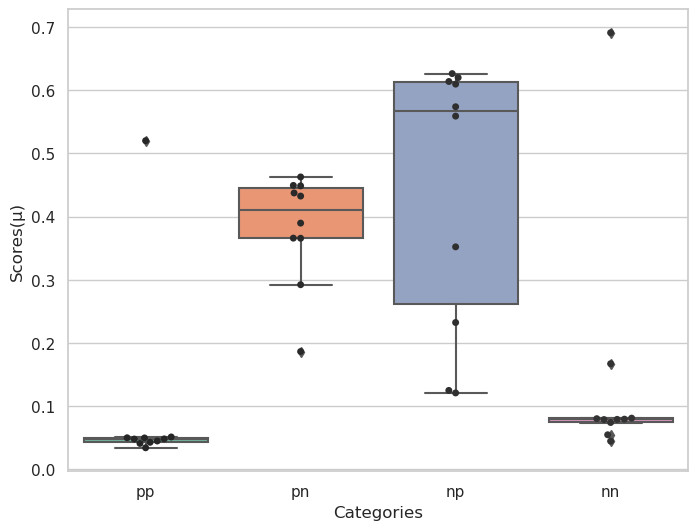

In [58]:
pp,pn,np,nn = eval_scores_average(
  model,
  test_data_loader,
  device,
)

box_plot(pp,pn,np,nn)

In [59]:
from parrot import Parrot
import torch
import warnings
warnings.filterwarnings("ignore")


def random_state(seed):
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

random_state(1234)

parrot = Parrot(model_tag="prithivida/parrot_paraphraser_on_T5")
clear_output()

In [60]:
#ORIGINAL EMOTION LABELS
positive_word_meaning_sentences = ['the feeling that you have when you enjoy something that is funny',#amusement
                                   'the state of feeling or showing happiness and enthusiasm',#excitement
                                   'a feeling of great happiness',#joy
                                   'a very strong feeling of liking and caring for somebody/something, especially a member of your family or a friend',#love
                                   'a strong wish to have or do something',#desire
                                   'a feeling that good things will happen and that something will be successful',#optimism
                                   'kind, helpful and showing that you care about other people',#caring
                                   'a feeling of being pleased or satisfied that you get when you or people who are connected with you have done something well or own something that other people admire',#pride
                                   'a feeling of respect for and approval of somebody/something',#admiration
                                   'the feeling of being grateful and wanting to express your thanks',#gratitude
                                   'the feeling of happiness that you have when something unpleasant stops or does not happen',#relief
                                   'the feeling that somebody/something is good or acceptable; a positive opinion of somebody/something',#approval
]

negative_word_meaning_sentences = ['the bad feeling that you have when you are in danger or when a particular thing frightens you',#fear
                                   'the feeling of being anxious about something or afraid of something',#nervousness
                                   'the feeling of being extremely sorry for something wrong or bad that you have done',#remorse
                                   'shy, uncomfortable or guilty feelings; a feeling of being embarrassed',#embarrassment
                                   'the feeling of being sad because something has not happened or been as good, successful, etc. as you expected or hoped',#disappointment
                                   'the feeling of being sad',#sadness
                                   'a very sad feeling, especially when somebody dies',#grief
                                   'a strong feeling of dislike for somebody/something that you feel is unacceptable, or for something that looks, smells, etc. unpleasant',#disgust
                                   'the strong feeling that you have when something has happened that you think is bad and unfair',#anger
                                   'the feeling of being slightly angry',#annoyance
                                   'a feeling that you do not like an idea, an action or somebody’s behaviour because you think it is bad, not suitable or going to have a bad effect on somebody else',#disapproval
]

In [61]:
from IPython.display import clear_output

In [62]:
new_positive_word_meaning_sentences = []

for i in positive_word_meaning_sentences:
  para_phrases = parrot.augment(input_phrase=i, max_return_phrases = 10)
  temp = list(list(zip(*para_phrases))[0])[0]
  new_positive_word_meaning_sentences.append(temp)


new_negative_word_meaning_sentences = []

for i in negative_word_meaning_sentences:
  para_phrases = parrot.augment(input_phrase=i, max_return_phrases = 10)
  temp = list(list(zip(*para_phrases))[0])[0]
  new_negative_word_meaning_sentences.append(temp)


clear_output()

Paraphrased Native Injection Accuracy

In [63]:
import numpy as np
p_emb = torch.tensor([[1.]*config.hidden_size]).to(device)
n_emb = torch.tensor([[1.]*config.hidden_size]).to(device)

for i in new_positive_word_meaning_sentences:
  p_emb = torch.cat((p_emb,get_cls(i).unsqueeze(dim=0)), dim=0)

for i in new_negative_word_meaning_sentences:
  n_emb = torch.cat((n_emb,get_cls(i).unsqueeze(dim=0)), dim=0)

p_emb = p_emb[1:]
n_emb = n_emb[1:]

test_acc, _, test_f1 = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)



print("Accuracy: ",test_acc.item())
print("F1-Macro: ",test_f1.item())

Accuracy:  0.831163708086785
F1-Macro:  0.8108028285902705


In [64]:
import random
random.seed(42)

inputNumbers = range(0,10000)
random_seeds = random.sample(inputNumbers, 300)

In [65]:
import numpy as np

In [66]:
f1s = []
accuracy = []
p_word_list = []
n_word_list = []

print("Working", end=' ')
for i in range(300):
    #SELECT RANDOM WORDS FROM NEUTRAL SENTIWORD
    df_neutral = df_senti[df_senti['Sentiment']=='Neutral'].sample(n=20, random_state=random_seeds[i])
    neutral_words = list(df_neutral["Word"])

    #FETCH DEFINITIONS OF THOSE WORDS
    neutral_word_meaning_sentences = []
    for i in neutral_words:
        a = list(df_senti.loc[df_senti['Word'] == i, 'Definition'])[0]
        neutral_word_meaning_sentences.append(a)

    #MAKE EMBEDDING OF THESE DEFINITIONS
    neutral_p_emb = torch.tensor([[1.]*config.hidden_size]).to(device)
    neutral_n_emb = torch.tensor([[1.]*config.hidden_size]).to(device)


    for i in neutral_word_meaning_sentences[0:10]:
      neutral_p_emb = torch.cat((neutral_p_emb,get_cls(i).unsqueeze(0)), dim=0)

    for i in neutral_word_meaning_sentences[10:20]:
      neutral_n_emb = torch.cat((neutral_n_emb,get_cls(i).unsqueeze(0)), dim=0)

    p_emb = neutral_p_emb[1:]
    n_emb = neutral_n_emb[1:]

    print('...', end=' ')

    p_samples = neutral_words[0:10]
    n_samples = neutral_words[10:20]

    #EVALUATE ON THESE WORDS
    test_acc,_, test_f1 = eval_model(
      model,
      test_data_loader,
      loss_fn,
      device,
      len(df_test),
    )

    accuracy.append(test_acc.item())
    f1s.append(test_f1.item())
    p_word_list.append(p_samples)
    n_word_list.append(n_samples)


Working ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... 

In [67]:
import statistics

In [68]:
stdv = statistics.pstdev(f1s)
median = statistics.median(f1s)
#filters = [i>median+(2*stdv) for i in f1s]
filters = [i>.7 for i in f1s]
def filter_2std(target_list, filters):
    index = [i for i in range(len(filters)) if filters[i]]
    list_a_filtered = [target_list[i] for i in index]
    return list_a_filtered

p_words_spurious = filter_2std(p_word_list,filters)
n_words_spurious = filter_2std(n_word_list,filters)

#print(p_words_spurious)
#print(n_words_spurious)

Neutral Injection Accuracies

In [69]:
import numpy as np

In [70]:
(hist, bin_edges) = np.histogram(f1s,bins=15)

In [71]:
#f1s = list(pd.read_csv('/home/m_nsu/ICLR/bert_randomizationtest.csv')['f1s'])

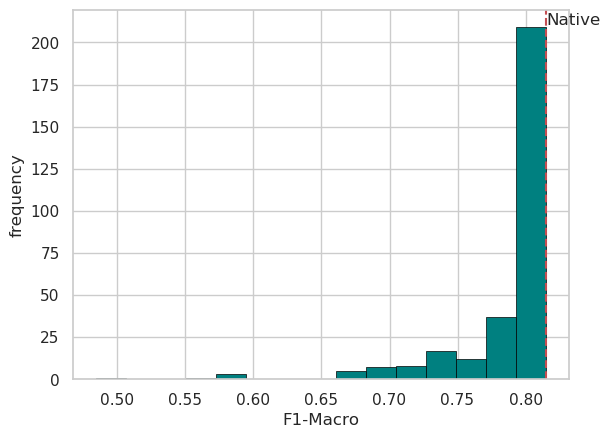

In [72]:
plt.hist(f1s, bins=15,facecolor = '#008080', edgecolor='#000000', linewidth=0.5)


vertical_line_position = 0.815  # Change this to the desired position
plt.axvline(x=vertical_line_position, color='r', linestyle='--', label='Vne')
plt.text(x=vertical_line_position,y=max(hist),s='Native',ha='left', va='bottom')

    
plt.xlabel("F1-Macro")
plt.ylabel("frequency")

#plt.title("bert-base")
plt.show()

In [73]:
'''
df_randomization_test = pd.DataFrame(list(zip(f1s, accuracy,p_word_list,n_word_list)),
               columns =['f1s', 'accuracy','p_word_list','n_word_list'])
df_randomization_test.to_csv('bert_randomizationtest.csv')
'''

"\ndf_randomization_test = pd.DataFrame(list(zip(f1s, accuracy,p_word_list,n_word_list)),\n               columns =['f1s', 'accuracy','p_word_list','n_word_list'])\ndf_randomization_test.to_csv('bert_randomizationtest.csv')\n"

In [74]:
df_neutral = df_senti[df_senti['Sentiment']=='Neutral'].sample(n=20, random_state=random_seeds[16])
neutral_words = list(df_neutral["Word"])

#FETCH DEFINITIONS OF THOSE WORDS
neutral_word_meaning_sentences = []
for i in neutral_words:
    a = list(df_senti.loc[df_senti['Word'] == i, 'Definition'])[0]
    neutral_word_meaning_sentences.append(a)

In [75]:
import numpy as np
p_emb = torch.tensor([[1.]*config.hidden_size]).to(device)
n_emb = torch.tensor([[1.]*config.hidden_size]).to(device)

for i in neutral_word_meaning_sentences[0:10]:
  p_emb = torch.cat((p_emb,get_cls(i).unsqueeze(dim=0)), dim=0)

for i in neutral_word_meaning_sentences[10:20]:
  n_emb = torch.cat((n_emb,get_cls(i).unsqueeze(dim=0)), dim=0)

p_emb = p_emb[1:]
n_emb = n_emb[1:]

test_acc, _, test_f1 = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)


print("Accuracy: ",test_acc.item())
print("F1-Macro: ",test_f1.item())

Accuracy:  0.7999999999999999
F1-Macro:  0.7663454669516407


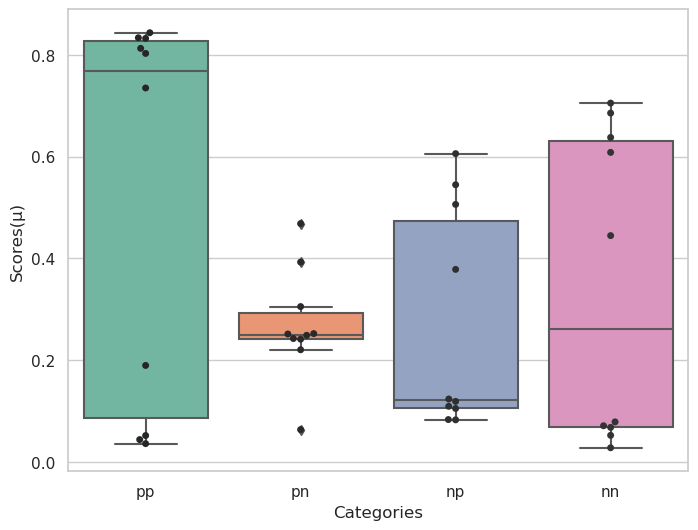

In [76]:
pp,pn,np,nn = eval_scores_average(
  model,
  test_data_loader,
  device,
)

box_plot(pp,pn,np,nn)

In [77]:
max_f1_index = f1s.index(max(f1s))

In [78]:
p_spurious_sentences = [list(df_senti[df_senti['Word'] == i]['Definition'])[0] for i in p_words_spurious[max_f1_index]]
n_spurious_sentences = [list(df_senti[df_senti['Word'] == i]['Definition'])[0] for i in n_words_spurious[max_f1_index]]

Accuracy:  0.8307692307692307
F1-Macro:  0.8095342665287977


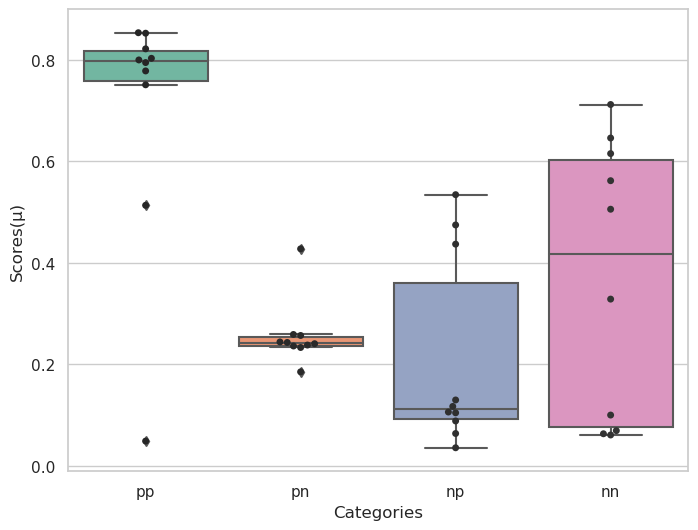

In [79]:
import numpy as np
p_emb = torch.tensor([[1.]*config.hidden_size]).to(device)
n_emb = torch.tensor([[1.]*config.hidden_size]).to(device)

for i in p_spurious_sentences:
  p_emb = torch.cat((p_emb,get_cls(i).unsqueeze(dim=0)), dim=0)

for i in n_spurious_sentences:
  n_emb = torch.cat((n_emb,get_cls(i).unsqueeze(dim=0)), dim=0)

p_emb = p_emb[1:]
n_emb = n_emb[1:]

test_acc, _, test_f1 = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

print("Accuracy: ",test_acc.item())
print("F1-Macro: ",test_f1.item())


pp,pn,np,nn = eval_scores_average(
  model,
  test_data_loader,
  device,
)

box_plot(pp,pn,np,nn)

In [80]:
n_words_spurious[0]

['thunnus genus_thunnus',
 'rajidae family_rajidae',
 'brush_fire',
 'genus_aethionema aethionema',
 'plane_table',
 'succus juice',
 'simplex',
 'disqualify',
 'go_board',
 'sunnah sunna hadith']

In [81]:
p_words_spurious[0]

['megagametophyte',
 'woolly_thistle scotch_thistle onopordum_acanthium onopordon_acanthium cotton_thistle',
 'grubstake',
 'sit#',
 'correspondence_school',
 'cricket_match',
 'baseball_season',
 'nasopharyngeal',
 'harness',
 'alundum']

Using Bias categories to test if they are neutral or not

In [82]:
import os, sys

filenames = []

path = "/home/m_nsu/ICLR/Datasets/GoEmotion/bias_criterias"
dir = os.listdir( path )

for file in dir:
   if(file.endswith('.csv')):
    filenames.append(file)

In [83]:
import numpy as np
for filename in filenames:
    df_bias = pd.read_csv('/home/m_nsu/ICLR/Datasets/GoEmotion/bias_criterias/'+filename)

    p_spurious_sentences = list(df_bias['Definition'])

    p_emb = torch.tensor([[1.]*config.hidden_size]).to(device)
    n_emb = torch.tensor([[1.]*config.hidden_size]).to(device)

    for i in p_spurious_sentences:
      p_emb = torch.cat((p_emb,get_cls(i).unsqueeze(dim=0)), dim=0)

    for i in neutral_word_meaning_sentences[10:20]:
      n_emb = torch.cat((n_emb,get_cls(i).unsqueeze(dim=0)), dim=0)

    p_emb = p_emb[1:]
    n_emb = n_emb[1:]

    test_acc, _, test_f1 = eval_model(
      model,
      test_data_loader,
      loss_fn,
      device,
      len(df_test)
    )

    positive_spurious = test_f1.item()

    n_spurious_sentences = list(df_bias['Definition'])
    p_emb = torch.tensor([[1.]*config.hidden_size]).to(device)
    n_emb = torch.tensor([[1.]*config.hidden_size]).to(device)

    for i in neutral_word_meaning_sentences[0:10]:
      p_emb = torch.cat((p_emb,get_cls(i).unsqueeze(dim=0)), dim=0)

    for i in n_spurious_sentences:
      n_emb = torch.cat((n_emb,get_cls(i).unsqueeze(dim=0)), dim=0)

    p_emb = p_emb[1:]
    n_emb = n_emb[1:]

    test_acc, _, test_f1 = eval_model(
      model,
      test_data_loader,
      loss_fn,
      device,
      len(df_test)
    )

    negative_spurious = test_f1.item()

    if positive_spurious>=0.6:
      print(filename+' is Positively Spurious.')
    if negative_spurious>=0.6:
      print(filename+' is Negatively Spurious.')
    if(positive_spurious<0.6 and negative_spurious<0.6):
      print(filename+' is Neutral.')
    print('Positive Acc:',positive_spurious,'\n'+'Negative Acc:', negative_spurious)
    print("------------------------------------------------------------------------")

Advocate.csv is Positively Spurious.
Advocate.csv is Negatively Spurious.
Positive Acc: 0.8139978343490666 
Negative Acc: 0.6837036646309669
------------------------------------------------------------------------
Dialogue.csv is Positively Spurious.
Positive Acc: 0.8106342348363533 
Negative Acc: 0.5495738957632732
------------------------------------------------------------------------
Indian.csv is Positively Spurious.
Indian.csv is Negatively Spurious.
Positive Acc: 0.810624027245748 
Negative Acc: 0.6833504218879306
------------------------------------------------------------------------
Orientation.csv is Positively Spurious.
Positive Acc: 0.8110451090737474 
Negative Acc: 0.5432007208024967
------------------------------------------------------------------------
Colored.csv is Positively Spurious.
Colored.csv is Negatively Spurious.
Positive Acc: 0.8108120985147227 
Negative Acc: 0.7238016500150313
------------------------------------------------------------------------
occupati